In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import sqlite3 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint


import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [2]:
db_path = os.path.join('..', 'data', 'database_credito.db')

try:
    conn = sqlite3.connect(db_path)
    print("Conectado a la base de datos con éxito")
except sqlite3.OperationalError as e:
    print(f"Error al abrir la base de datos: {e}")

Conectado a la base de datos con éxito


In [3]:

data_modelar = pd.read_sql('SELECT * FROM Datos_train_procesados', conn)
conn.close()

In [4]:
data_modelar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69511 entries, 0 to 69510
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Edad                              69511 non-null  int64  
 1   Ingreso_Anual                     69511 non-null  float64
 2   Salario_Mensual_En_Mano           69511 non-null  float64
 3   Numero_Cuentas_Bancarias          69511 non-null  int64  
 4   Numero_Tarjetas_Credito           69511 non-null  int64  
 5   Tasa_Interes                      69511 non-null  int64  
 6   Retraso_Promedio_Pagos            69511 non-null  int64  
 7   Numero_Promedio_Pagos_Retrasados  69511 non-null  float64
 8   Cambio_Limite_Credito             69511 non-null  float64
 9   Numero_Consultas_Credito          69511 non-null  float64
 10  Deuda_Pendiente                   69511 non-null  float64
 11  Ratio_Uso_Credito                 69511 non-null  float64
 12  Anti

Hacemos el split de datos conservando el random state para repetibilidad 

In [11]:
X = data_modelar.drop('Puntaje_Credito', axis=1)
y = data_modelar['Puntaje_Credito']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Entrenamos el modelo con valores de default

In [12]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8073077753002948
Matriz de Confusión:
[[3199  683   51]
 [ 803 6284  496]
 [  12  634 1741]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      3933
           1       0.83      0.83      0.83      7583
           2       0.76      0.73      0.74      2387

    accuracy                           0.81     13903
   macro avg       0.79      0.79      0.79     13903
weighted avg       0.81      0.81      0.81     13903



In [18]:

# Crear el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Inicialmente configuramos el StandardScaler
    ('classifier', RandomForestClassifier(random_state=42))
])


In [19]:
# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'classifier__n_estimators': randint(100, 1000),  # Número de árboles entre 100 y 1000
    'classifier__max_depth': [None] + list(randint(10, 50).rvs(10)),  # Profundidad máxima entre 10 y 50, más None
    'classifier__min_samples_split': randint(2, 20),  # Muestras mínimas para dividir un nodo entre 2 y 20
    'classifier__min_samples_leaf': randint(1, 20),  # Muestras mínimas en cada hoja entre 1 y 20
    'classifier__bootstrap': [True, False]  # Si usar bootstrap o no
}

In [20]:

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, n_jobs=-1, random_state=42)


random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [None,
                                                                  np.int64(35),
                                                                  np.int64(43),
                                                                  np.int64(12),
                                                                  np.int64(36),
                                                                  np.int64(27),
                                                                  np.int64(37),
                                                                  np.int64(49),
                                                                  np.int64(36),
                                                                  np...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029963EBE720>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002994326AE70>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029963EBE810>,
                                        'scaler': [StandardScaler(),
                                                   MinMaxScaler(),
                                                   RobustScaler()]},
                   random_state=42, verbose=2)

In [21]:

results = pd.DataFrame(random_search.cv_results_)

results = results[['mean_test_score', 'std_test_score', 'param_scaler', 
                   'param_classifier__n_estimators', 'param_classifier__max_depth', 
                   'param_classifier__min_samples_split', 'param_classifier__min_samples_leaf', 
                   'param_classifier__bootstrap']]


top_results = results.sort_values(by='mean_test_score', ascending=False).head(5)
print(top_results)

    mean_test_score  std_test_score      param_scaler  \
20         0.795713        0.005432    RobustScaler()   
36         0.794868        0.005037  StandardScaler()   
2          0.794382        0.005877    MinMaxScaler()   
40         0.793807        0.005606    MinMaxScaler()   
3          0.793519        0.005915    MinMaxScaler()   

    param_classifier__n_estimators  param_classifier__max_depth  \
20                             317                         43.0   
36                             610                         36.0   
2                              443                         49.0   
40                             572                         49.0   
3                              413                         35.0   

    param_classifier__min_samples_split  param_classifier__min_samples_leaf  \
20                                    6                                   1   
36                                    7                                   2   
2                

In [24]:
top_results

,mean_test_score,std_test_score,param_scaler,param_classifier__n_estimators,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__bootstrap
20,0.795713,0.005432,RobustScaler(),317,43.0,6,1,False
36,0.794868,0.005037,StandardScaler(),610,36.0,7,2,False
2,0.794382,0.005877,MinMaxScaler(),443,49.0,3,3,False
40,0.793807,0.005606,MinMaxScaler(),572,49.0,12,1,False
3,0.793519,0.005915,MinMaxScaler(),413,35.0,13,1,False


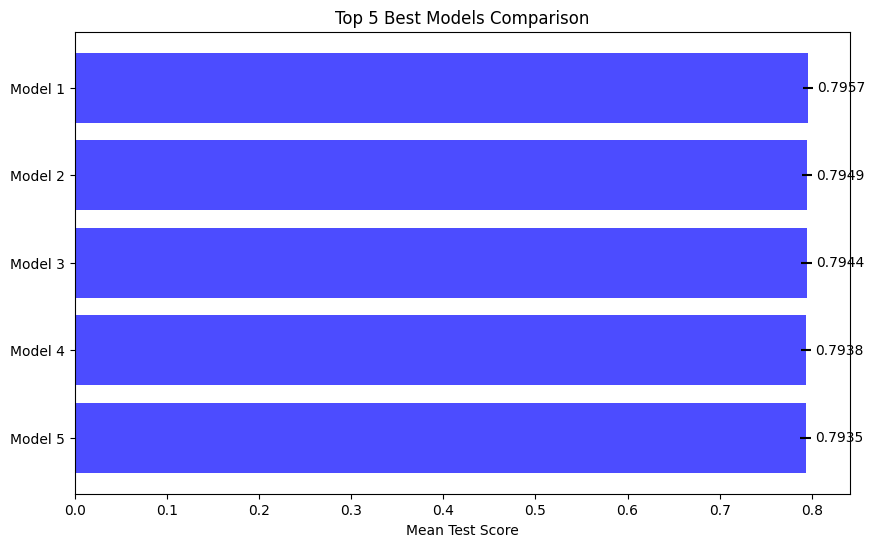

In [23]:
# Crear un gráfico de barras para comparar los 5 mejores modelos
plt.figure(figsize=(10, 6))
bars = plt.barh(np.arange(len(top_results)), top_results['mean_test_score'], 
                xerr=top_results['std_test_score'], align='center', 
                alpha=0.7, color='blue')

# Añadir etiquetas de los números de accuracy sobre las barras
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, 
             f'{top_results["mean_test_score"].iloc[i]:.4f}', 
             va='center', ha='left', color='black')

plt.yticks(np.arange(len(top_results)), [f'Model {i+1}' for i in range(len(top_results))])
plt.xlabel('Mean Test Score')
plt.title('Top 5 Best Models Comparison')
plt.gca().invert_yaxis()  # Invertir el eje y para que el mejor modelo esté arriba
plt.show()


In [16]:
Counter(data_modelar['Puntaje_Credito'])

Counter({1: 37759, 0: 19878, 2: 11874})

In [17]:
def train_test_data(dataframe, nombre_objetivo, test_size=0.2, random_state=42):
    global X, y, X_train, X_test, y_train, y_test
    X = dataframe.drop(nombre_objetivo, axis=1)
    y = dataframe[nombre_objetivo]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test


In [18]:
train_test_data(data_modelar, 'Puntaje_Credito', 0.2, 42)

(       Edad  Ingreso_Anual  Salario_Mensual_En_Mano  Numero_Cuentas_Bancarias  \
 12203    42      20774.340              1702.195000                         6   
 41794    38      34982.690              2851.224167                         5   
 42708    52      34269.740              2950.811667                         4   
 41737    23      33121.690              3009.140833                         3   
 27450    36      17955.380              1428.281667                         3   
 ...     ...            ...                      ...                       ...   
 37194    37      35185.560              3803.256417                         6   
 6265     55     129903.880             10538.323333                         7   
 54886    38      22387.125              1677.593750                         4   
 860      31      59971.420              4870.570833                         8   
 15795    40      19206.920              1373.576667                         7   
 
        Numero

In [19]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Ver la nueva distribución de las clases después de aplicar SMOTE
print(f"Nueva distribución de las clases: {Counter(y_resampled)}")

Nueva distribución de las clases: Counter({0: 30176, 1: 30176, 2: 30176})


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definir el modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos balanceados
model.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

In [22]:
# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en el conjunto de prueba: {accuracy * 100:.2f}%")

# Mostrar un informe de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la matriz de confusión
print(confusion_matrix(y_test, y_pred))


Accuracy en el conjunto de prueba: 80.65%
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3933
           1       0.85      0.80      0.82      7583
           2       0.73      0.78      0.75      2387

    accuracy                           0.81     13903
   macro avg       0.79      0.80      0.79     13903
weighted avg       0.81      0.81      0.81     13903

[[3297  560   76]
 [ 904 6064  615]
 [  20  515 1852]]
